# Reading Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from utils.split_sets import load_data
from sklearn.model_selection import train_test_split
import pandas as pd

x_train, x_test, x_val, y_train, y_test, y_val, metadata_train, metadata_test, metadata_val = load_data('fco')
print(f'orignal data sizes: train size: {x_train.shape[0]} test size: {x_test.shape[0]} val size: {x_val.shape[0]}')

orignal data sizes: train size: 2137 test size: 100 val size: 64


In [2]:
def print_set_labels(y_set, name):
    unique, counts = np.unique(y_set, return_counts=True)
    for idx, c in enumerate(counts):
        print(f'{name}: label: {idx}: {c} samples')

print_set_labels(y_train, 'y_train')
print_set_labels(y_test, 'y_test')
print_set_labels(y_val, 'y_test')
print('\ntrain data still un balanced!')

y_train: label: 0: 2057 samples
y_train: label: 1: 80 samples
y_test: label: 0: 50 samples
y_test: label: 1: 50 samples
y_test: label: 0: 32 samples
y_test: label: 1: 32 samples

train data still un balanced!


# Augmentation + Upsampling

In [3]:
import pandas as pd
from utils.general import rand_shot
from tqdm.notebook import tqdm

def stack_data(data_pos_, data_neg_, data_new, stack_foo):
    '''
    stack x,y, metadata at the same fashion such that the indices will align
    '''
    data_pos_ = stack_foo((data_pos_, data_new))
    return stack_foo((data_pos_, data_neg_))


frame_prob = 1

pos = np.where(y_train==1)
neg = np.where(y_train==0)

metadata_pos = metadata_train[pos]
metadata_neg = metadata_train[neg]

data_pos = x_train[pos]
data_neg = x_train[neg]

y_pos = y_train[pos]
y_neg = y_train[neg]

up_sample_amount = len(neg[0]) - len(pos[0])
print(f'generating {up_sample_amount} shots')

new_data = []
new_metadata = []
new_y = np.ones(up_sample_amount)

rand_amount = 0
run_ = True

with tqdm(total=up_sample_amount) as pbar:
    while run_:
        for shot_idx, shot in enumerate(data_pos):
            amount = metadata_pos[shot_idx]['frames']
            name = metadata_pos[shot_idx]['name']
            new_shot = rand_shot(shot, amount, frame_prob=frame_prob)
            
            new_metadata.append({'name': f'{name}_rand_{rand_amount}', 'frames': amount})
            new_data.append(new_shot)
            
            rand_amount += 1 
            pbar.update(1)
            
            if rand_amount == up_sample_amount:
                run_ = False
                break

new_data_pos = torch.stack([shot for shot in new_data])

x_train = stack_data(data_pos, data_neg, new_data_pos, torch.vstack)
y_train = stack_data(y_pos, y_neg, new_y, np.concatenate)
metadata_train = stack_data(metadata_pos, metadata_neg, new_metadata, np.concatenate)

print('x train shape', x_train.shape)
print_set_labels(y_train, 'y_train')
print('\ntrain data is now balanced!')

generating 1977 shots


  0%|          | 0/1977 [00:00<?, ?it/s]

x train shape torch.Size([4114, 50, 100])
y_train: label: 0: 2057 samples
y_train: label: 1: 2057 samples

train data is now balanced!


# Feature Selection

In [4]:
def feature_selection(x_set, remove_features):
    idxs = []
    for p in remove_features:
        idxs.extend(list(range(p*4, p*4 + 4)))
    return np.delete(x_set, idxs, axis=2)

head_landmarks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

remove_landmarks = []
x_train = feature_selection(x_train, remove_landmarks)
x_test = feature_selection(x_test, remove_landmarks)
x_val = feature_selection(x_val, remove_landmarks)


print(x_train.shape)
print(x_test.shape)
print(x_val.shape)


NUM_FEATURES = 100 - (len(remove_landmarks) * 4)

torch.Size([4114, 50, 100])
torch.Size([100, 50, 100])
torch.Size([64, 50, 100])


# Config

In [5]:
## Network
HIDDEN_DIM = 64
OUTPUT_DIM = 2
BATCH_SIZE = 32
IS_BID = True
NUM_LAYERS = 2

## Optimizer  
lr = 1e-3/5
weight_decay=0.001

## Scheduler
step_size=10
gamma=0.5

early_stop_patience = 8

# Data Set & Loaders

In [6]:
from torch.utils.data import Dataset, DataLoader

train_labels = pd.DataFrame({'label': y_train, 'metadata': metadata_train})
val_labels = pd.DataFrame({'label': y_val, 'metadata': metadata_val})
test_labels = pd.DataFrame({'label': y_test, 'metadata': metadata_test})


print(f'data sizes: train size: {x_train.shape[0]} val size: {x_val.shape[0]} test size: {x_test.shape[0]}')


class TTDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels.iloc[idx]['label'], idx

def create_dataloaders(batch_size):
    train_data = TTDataset(x_train, train_labels)
    test_data = TTDataset(x_test, test_labels)
    validation_data = TTDataset(x_val, val_labels)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
    
    return train_loader, validation_loader, test_loader

    
train_loader, validation_loader, test_loader = create_dataloaders(BATCH_SIZE)

data sizes: train size: 4114 val size: 64 test size: 100


# Learning

In [7]:
import torch.nn as nn
import math
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.scale = 1. / math.sqrt(hidden_size)

    def forward(self, hidden, outputs):
        hidden = hidden.unsqueeze(1)
        weights = torch.bmm(hidden, outputs.transpose(1, 2))

        scores = F.softmax(weights.mul_(self.scale), dim=2)
        linear_combination = torch.bmm(scores, outputs).squeeze(1)
        return linear_combination


class Network(nn.Module):
    def __init__(self, input_dim, h_dim, out_dim, num_layers,
                 bidirectional=True, use_attention=True):
        super().__init__()
        self.num_layers = num_layers
        self.h_dim = h_dim
        self.bidirectional = bidirectional
        self.use_attention = use_attention
        self.dropout = nn.Dropout(0.5)

        hid_bidirectional = h_dim * 2 if bidirectional else h_dim
        self.atten = Attention(hid_bidirectional)

        # LSTM
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=h_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional, batch_first=True, dropout=0.5)
        # FC layer
        self.fc = nn.Linear(hid_bidirectional, out_dim, bias=True)

        # To convert class scores to log-probability we'll apply log-softmax
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, X, batch_size):
        lay_times_dir = self.num_layers * 2 if self.bidirectional else self.num_layers
        h0 = torch.zeros(lay_times_dir, batch_size, HIDDEN_DIM).to(device)
        c0 = torch.zeros(lay_times_dir, batch_size, HIDDEN_DIM).to(device)

        out, (h_t, c_t) = self.lstm(X, (h0, c0))
        if self.bidirectional:
            cell_state = torch.cat([c_t[-1], c_t[-2]], dim=1)
        else:
            cell_state = c_t[-1]
        
        classify_input = self.atten(cell_state, out) if self.use_attention else cell_state
        y = self.fc(classify_input)
        
        yt_log_proba = self.log_softmax(y)
        return yt_log_proba

In [8]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


b32_lr0.0002_sz10_g0.5_h64_nl2_all_features_with_aug_with_attn.pt
epoch 0 | train loss : 0.6697397232055664 validation loss: 0.6478269696235657 
epoch 0 | train acc : 0.71728515625 validation acc: 0.640625 
epoch 1 | train loss : 0.5138435363769531 validation loss: 0.572565495967865 
epoch 1 | train acc : 0.8115234375 validation acc: 0.78125 
epoch 2 | train loss : 0.4253799021244049 validation loss: 0.5315544605255127 
epoch 2 | train acc : 0.82763671875 validation acc: 0.734375 
epoch 3 | train loss : 0.3827930688858032 validation loss: 0.4850289225578308 
epoch 3 | train acc : 0.85107421875 validation acc: 0.8125 
epoch 4 | train loss : 0.3549879789352417 validation loss: 0.48287874460220337 
epoch 4 | train acc : 0.816162109375 validation acc: 0.765625 
epoch 5 | train loss : 0.3233129680156708 validation loss: 0.40229660272598267 
epoch 5 | train acc : 0.902099609375 validation acc: 0.859375 
epoch 6 | train loss : 0.276439368724823 validation loss: 0.47012364864349365 
epoch 6 | 

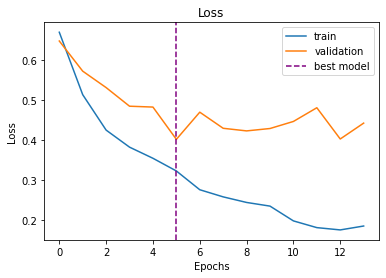

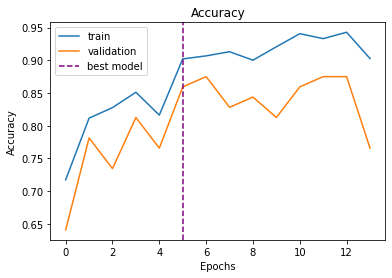

In [9]:
from utils.learn import train_model

# frame_prob = 0
use_attention = True
model = Network(NUM_FEATURES, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, 
                bidirectional=IS_BID, use_attention=use_attention).to(device)

features_name = 'all_features' if NUM_FEATURES == 100 else 'no_head'
aug_name = 'with_aug' if frame_prob > 0 else 'no_aug'
att_name = 'with_attn' if use_attention else 'no_attn'
model_name = f'b{BATCH_SIZE}_lr{lr}_sz{step_size}_g{gamma}_h{HIDDEN_DIM}_nl{NUM_LAYERS}_{features_name}_{aug_name}_{att_name}.pt'
print(model_name)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.NLLLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

train_model(model, model_name, BATCH_SIZE, device, early_stop_patience,
            train_loader, validation_loader, test_loader,
            optimizer, scheduler, loss_fn)

# False analysis 

prec 0.94
acc 0.94


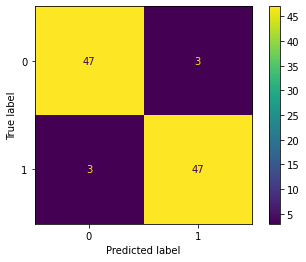

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score
from utils.learn import predict
from visualization import points_visualization
from IPython.display import Image

model.load_state_dict(torch.load('model_results/' + model_name))
model.eval()
correct_idx, wrong_idx, y_pred, y_true, confs = predict(model, test_loader, device, 1, 0.0)
print('prec', precision_score(y_true, y_pred))
print('acc', accuracy_score(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred, labels=[0,1] )#normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [11]:
# print('correct', correct_idx)
print('wrong', wrong_idx)
print()

debug_idx = 22
debug_name = test_labels.iloc[debug_idx]['metadata']['name']
debug_amount = test_labels.iloc[debug_idx]['metadata']['frames']

debug_X = x_test[debug_idx]

print('debug original idx in test set: ', debug_idx)
print('true label:', test_labels.iloc[debug_idx]['label'])
print('correct:', debug_idx in correct_idx)
print('shot name: ', debug_name)
print('frames', debug_amount)

wrong [24, 25, 33, 70, 85, 88]

debug original idx in test set:  22
true label: 1.0
correct: True
shot name:  fco_53_8.5_25
frames 9


finished saving gif: fco_53_8.5_25


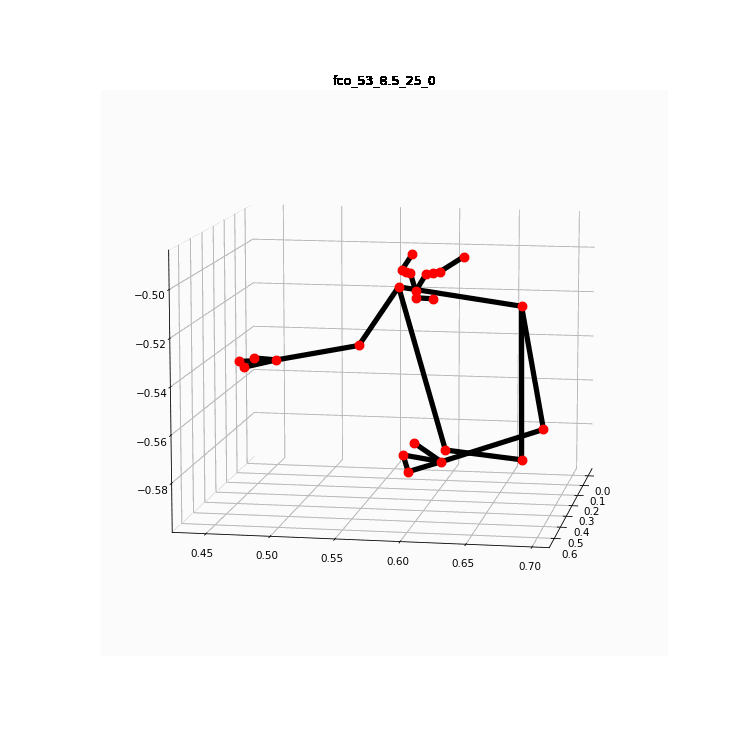

In [12]:
points_visualization.create_landmarks_gif(debug_name, debug_X, debug_amount, remove_landmarks)
with open(f'visualization/shots_3d_demo/{debug_name}.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=500, height=500))

In [13]:
# splitted = debug_name.split('_')
# shot_type = splitted[0]
# splitted = splitted[0:len(splitted)-1]
# shot_folder = '_'.join(splitted)
# vid_path = f'{shot_type}/{shot_folder}'

# gif_name = f'real_{debug_name}'
# points_visualization.create_vid_gif(vid_path, debug_name, debug_amount)
# with open(f'visualization/shots_3d_demo/{gif_name}.gif','rb') as f:
#     display(Image(data=f.read(), format='png', width=350, height=450))